In [3]:
import random

from importlib import reload
import plotting
import game

reload(plotting)
reload(game)

import plotting
import game

from game import Patterns
from plotting import PatternPlotter

In [4]:
my_patterns = Patterns()


0 [2, 1, 1, 3, 0, 2, 1, 4, 1, 1, 1, 4, 0, 3, 0, 3, 3, 4, 2, 2, 0, 4, 2, 2, 4, 3, 1, 5, 5, 3, 5, 4, 4, 5, 0, 3, 5, 5, 5, 5, 2, 3, 2, 2, 0, 0, 4, 4, 5, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6] None
Available actions are: [104, 105, 106]

action taken is: 105

1 [2, 1, 1, 3, 0, 2, 1, 4, 1, 1, 1, 4, 0, 3, 0, 3, 3, 4, 2, 2, 0, 4, 2, 2, 4, 3, 1, 5, 5, 3, 5, 4, 4, 5, 0, 3, 5, 5, 5, 5, 2, 3, 2, 2, 0, 0, 4, 4, 5, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 0


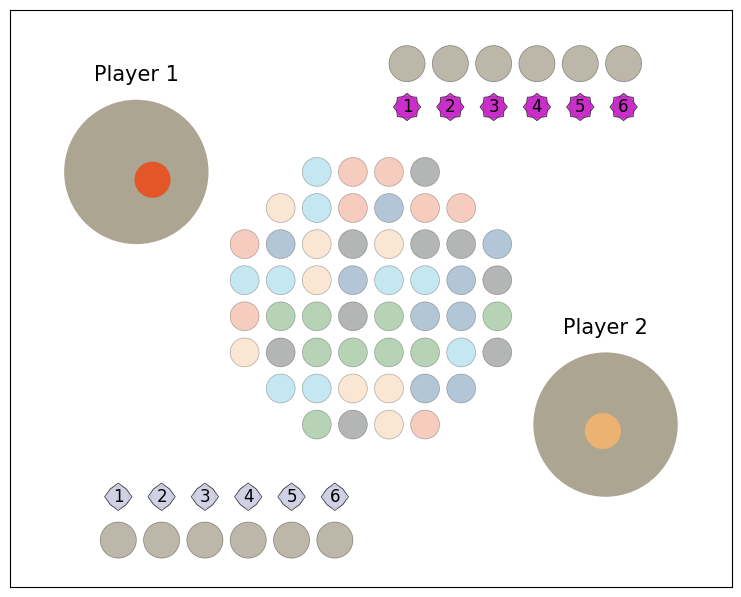

In [5]:
print()
print(my_patterns.player, my_patterns.active_state, my_patterns.active_hand_piece, )

actions = my_patterns.get_actions()

print(f"Available actions are: {actions}\n")

action = random.choice(actions)

print(f"action taken is: {action}\n")

my_patterns.step(action)

print(my_patterns.player, my_patterns.active_state, my_patterns.active_hand_piece)

pattern_plotter = PatternPlotter(my_patterns, fig_size=(10, 7.5))
pattern_plotter.populate_board()

Turn 1, for Player 1
Score is currently:
Player 1: 0 -- 0: Player 2
Available actions are: [104, 105, 106]
action taken is: 106


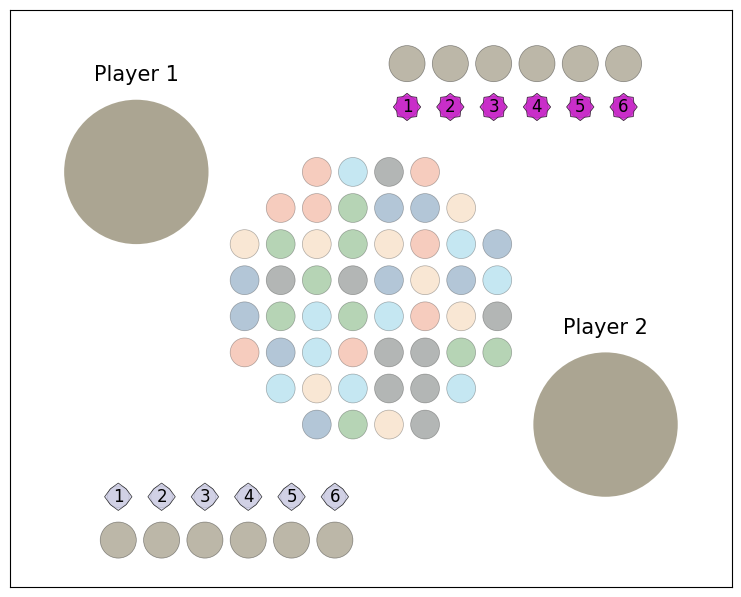

Turn 2, for Player 2
Score is currently:
Player 1: 0 -- 0: Player 2
Available actions are: [104, 105]
action taken is: 104


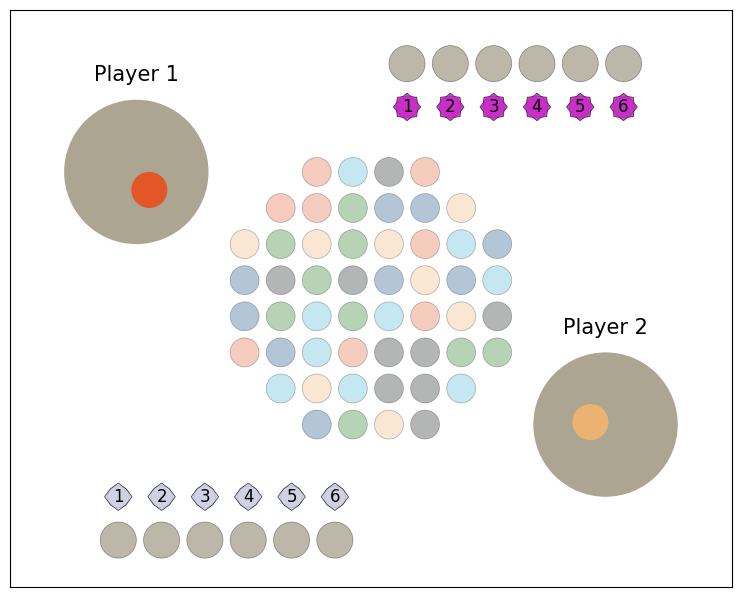

Turn 3, for Player 1
Score is currently:
Player 1: 0 -- 0: Player 2
Available actions are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
action taken is: 7


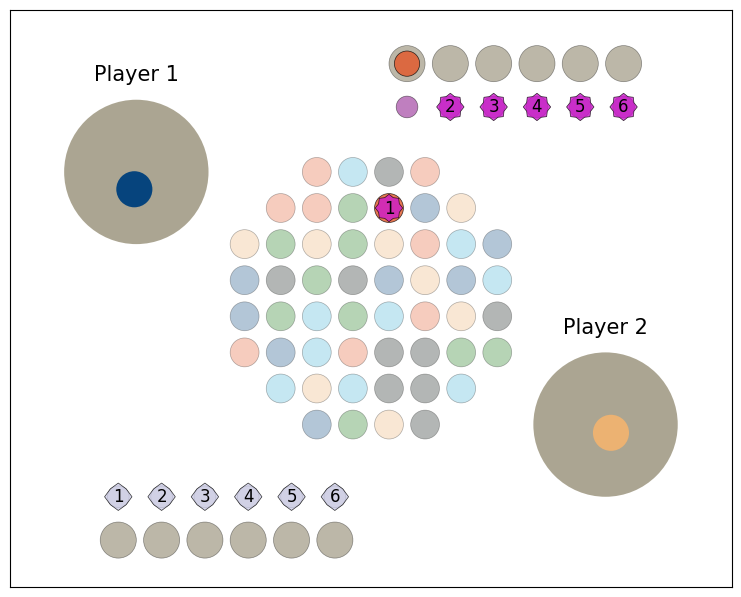

Turn 4, for Player 2
Score is currently:
Player 1: 1 -- 0: Player 2
Available actions are: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
action taken is: 6


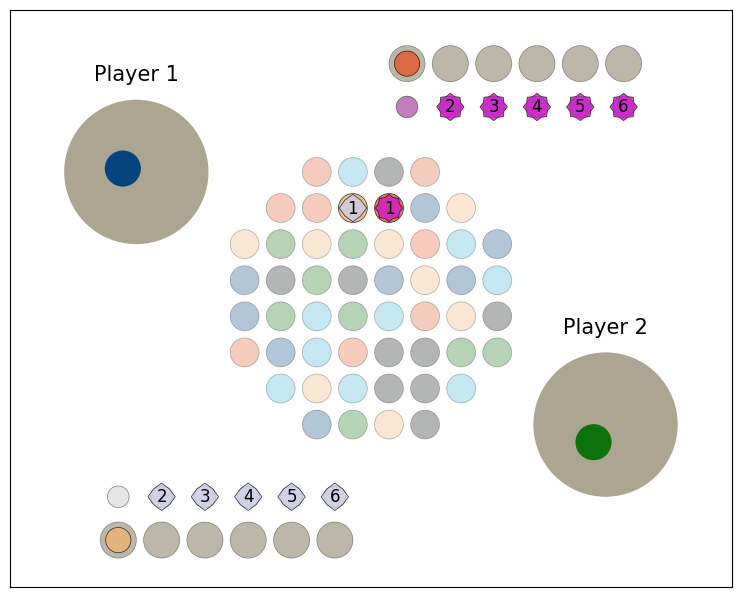

Turn 5, for Player 1
Score is currently:
Player 1: 1 -- 1: Player 2
Available actions are: [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
action taken is: 49


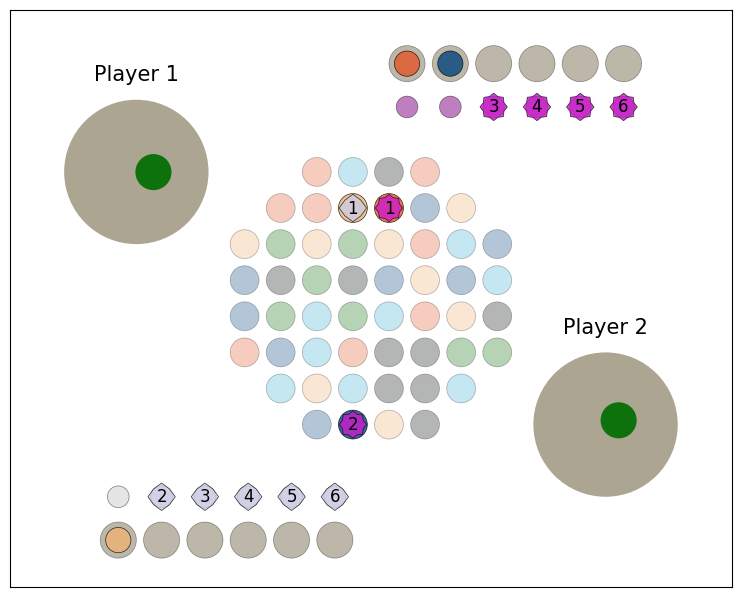

Turn 6, for Player 2
Score is currently:
Player 1: 3 -- 1: Player 2
Available actions are: [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51]
action taken is: 0


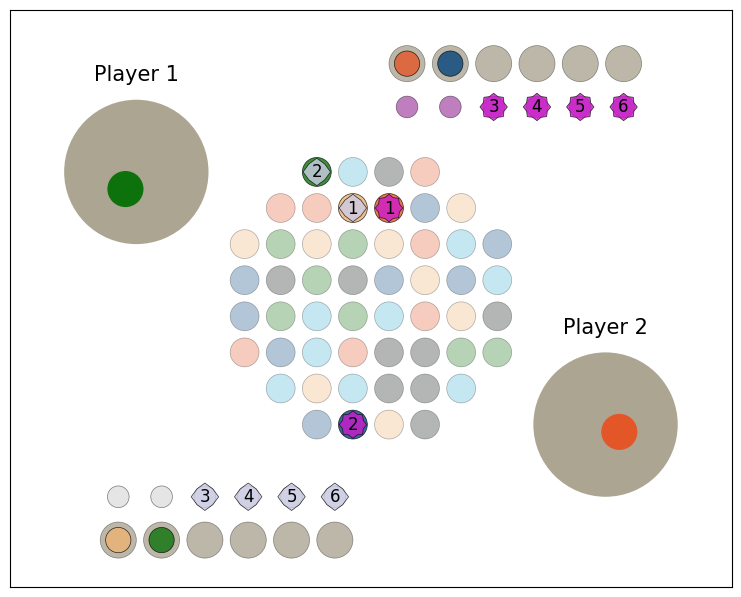

Turn 7, for Player 1
Score is currently:
Player 1: 3 -- 3: Player 2
Available actions are: [2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 100]
action taken is: 38


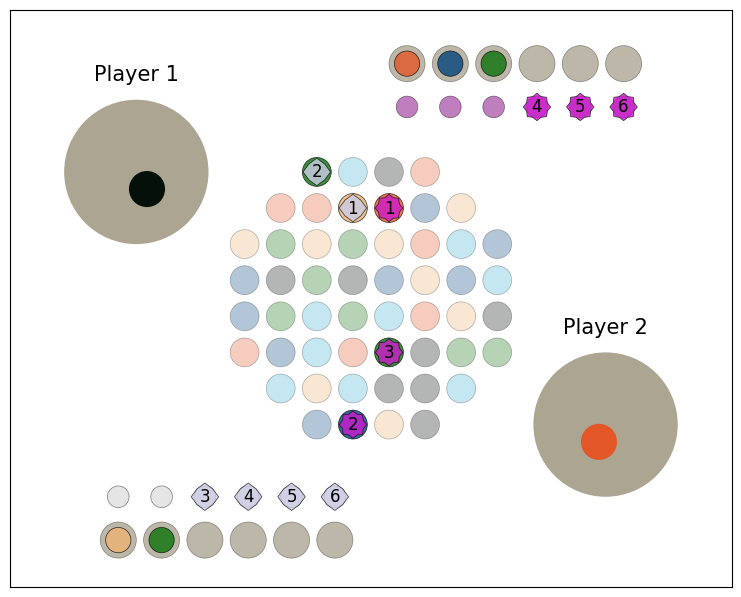

Turn 8, for Player 2
Score is currently:
Player 1: 6 -- 3: Player 2
Available actions are: [1, 3, 4, 5, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51]
action taken is: 40


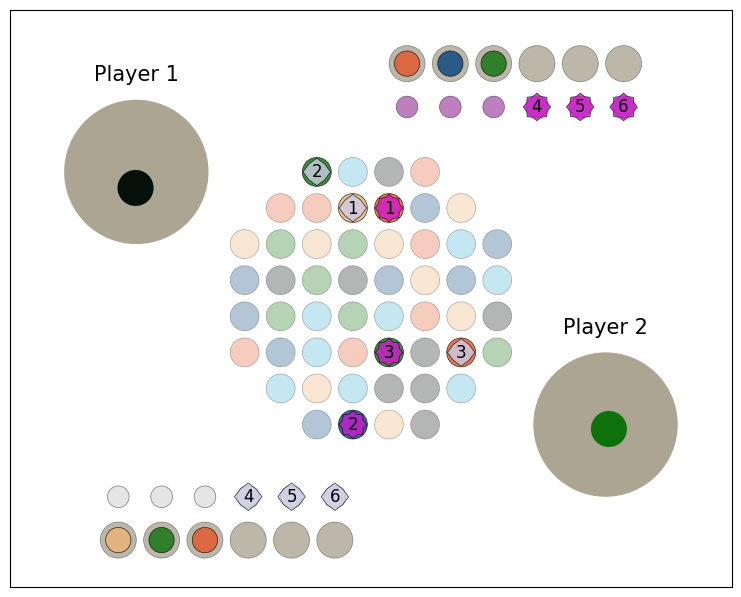

Turn 9, for Player 1
Score is currently:
Player 1: 6 -- 6: Player 2
Available actions are: [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 100]
action taken is: 31


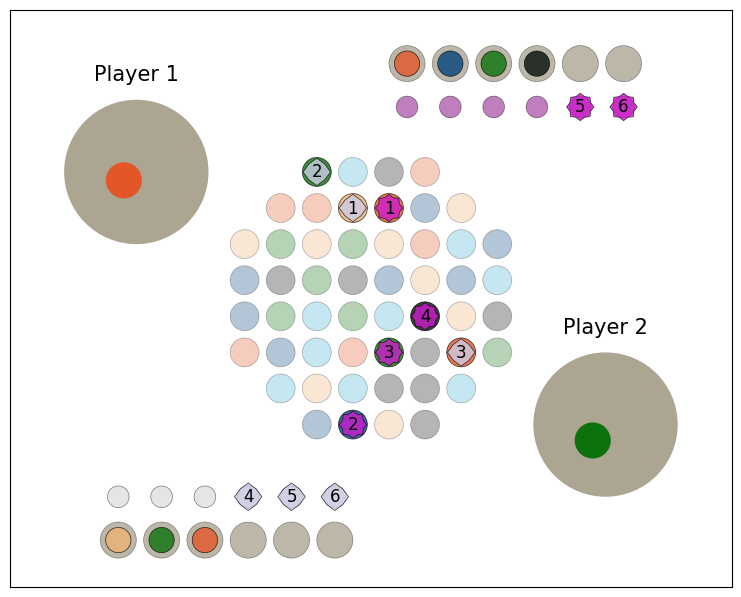

Turn 10, for Player 2
Score is currently:
Player 1: 10 -- 6: Player 2
Available actions are: [1, 5]
action taken is: 1


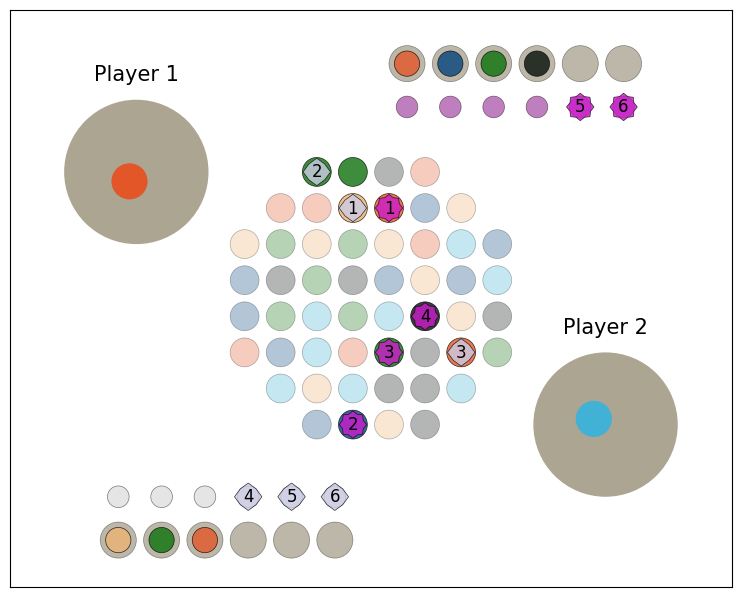

Turn 11, for Player 1
Score is currently:
Player 1: 10 -- 8: Player 2
Available actions are: [8, 2, 14, 100, 91]
action taken is: 2


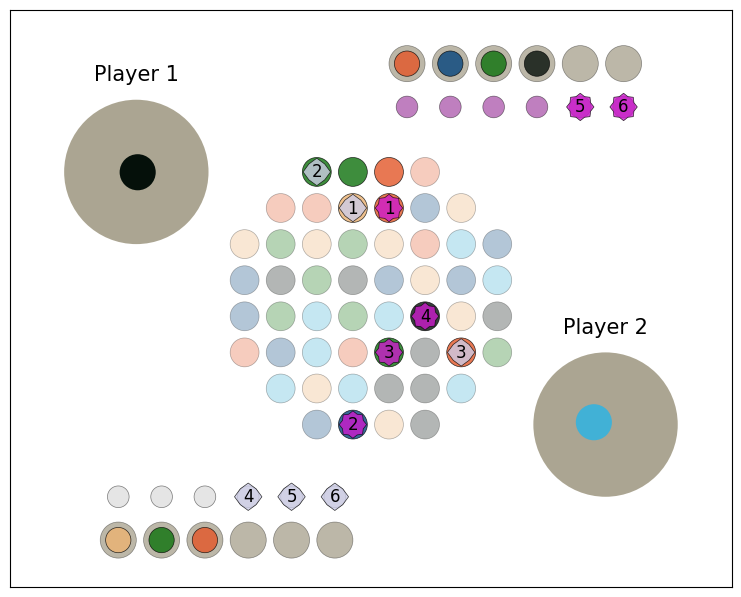

Turn 12, for Player 2
Score is currently:
Player 1: 11 -- 8: Player 2
Available actions are: [3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51]
action taken is: 16


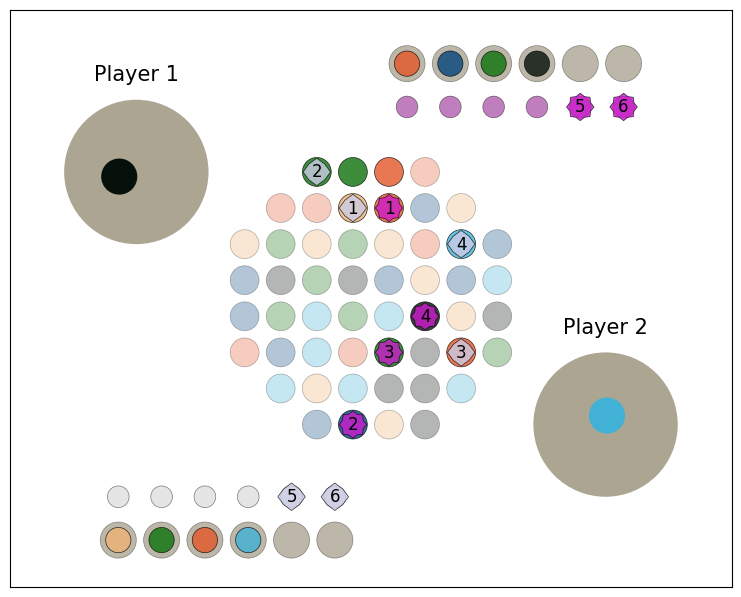

Turn 13, for Player 1
Score is currently:
Player 1: 11 -- 12: Player 2
Available actions are: [32, 23, 30, 39, 55, 100, 91]
action taken is: 39


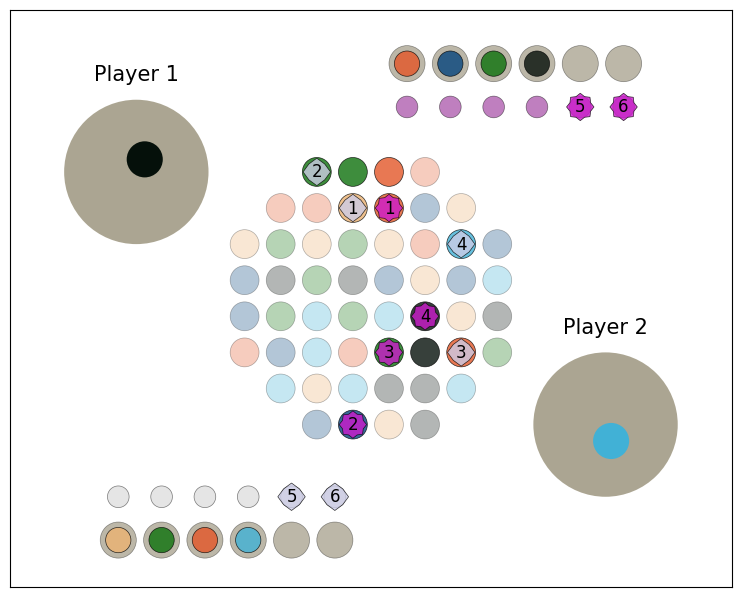

Turn 14, for Player 2
Score is currently:
Player 1: 15 -- 12: Player 2
Available actions are: [24, 17, 9, 15]
action taken is: 9


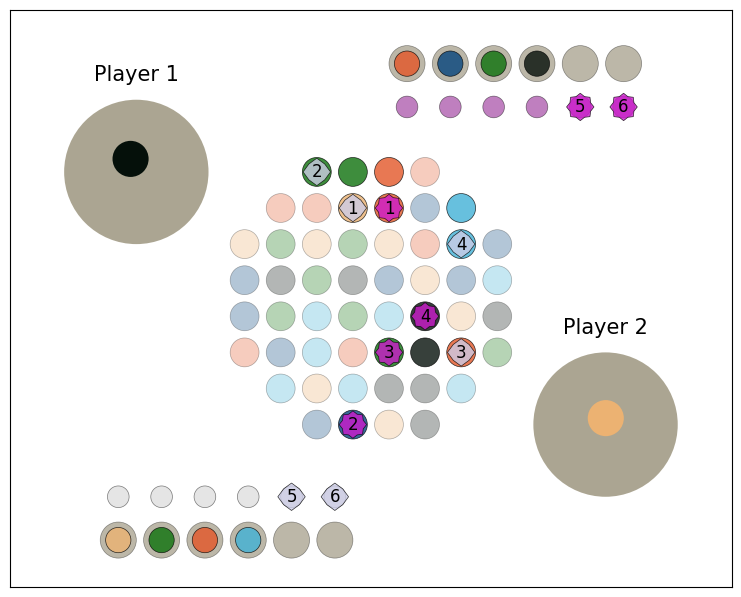

Turn 15, for Player 1
Score is currently:
Player 1: 15 -- 16: Player 2
Available actions are: [32, 30, 46, 23, 55, 100, 98]
action taken is: 30


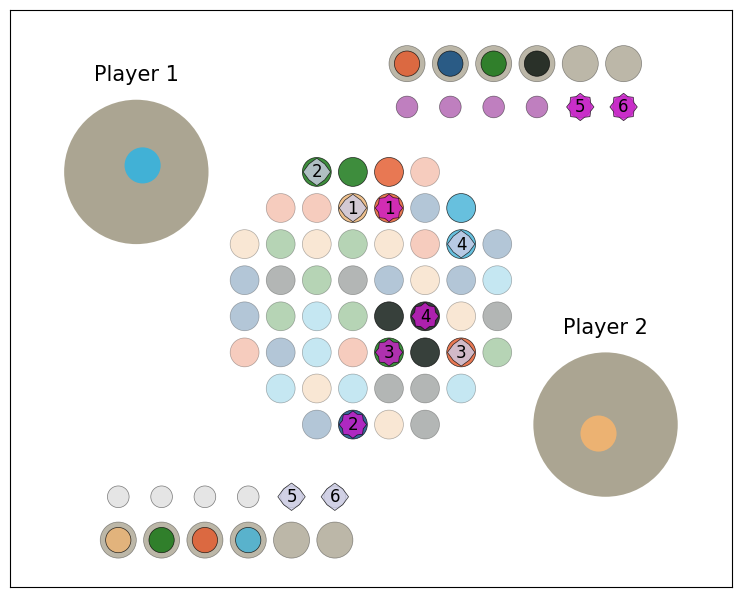

Turn 16, for Player 2
Score is currently:
Player 1: 19 -- 16: Player 2
Available actions are: [5, 13]
action taken is: 13


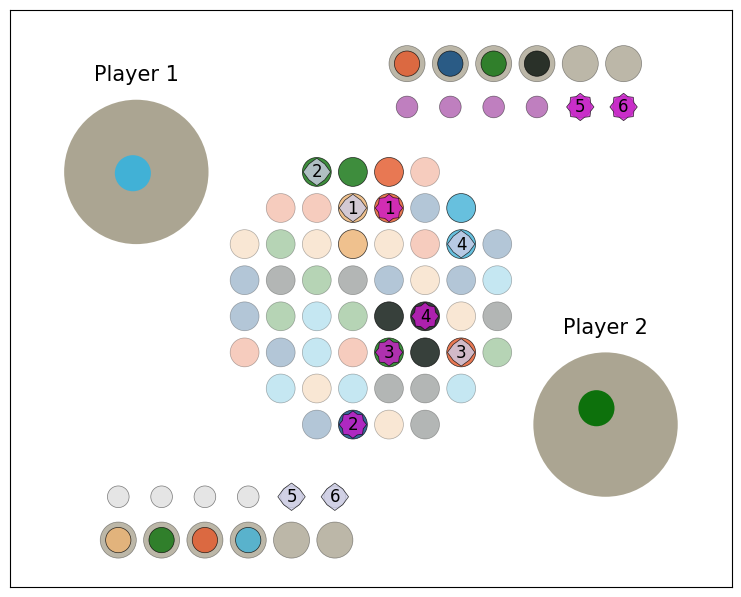

Turn 17, for Player 1
Score is currently:
Player 1: 19 -- 17: Player 2
Available actions are: [3, 4, 5, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 55, 100, 98]
action taken is: 47


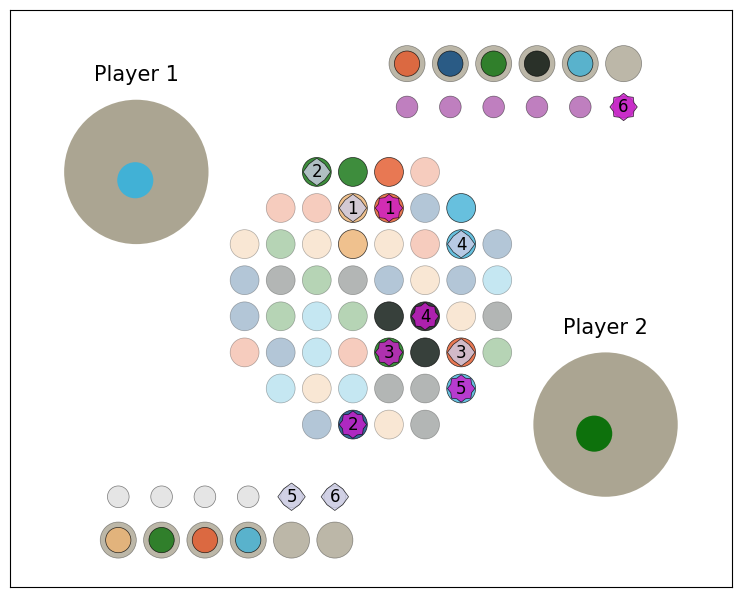

Turn 18, for Player 2
Score is currently:
Player 1: 24 -- 17: Player 2
Available actions are: [5, 64, 66]
action taken is: 66


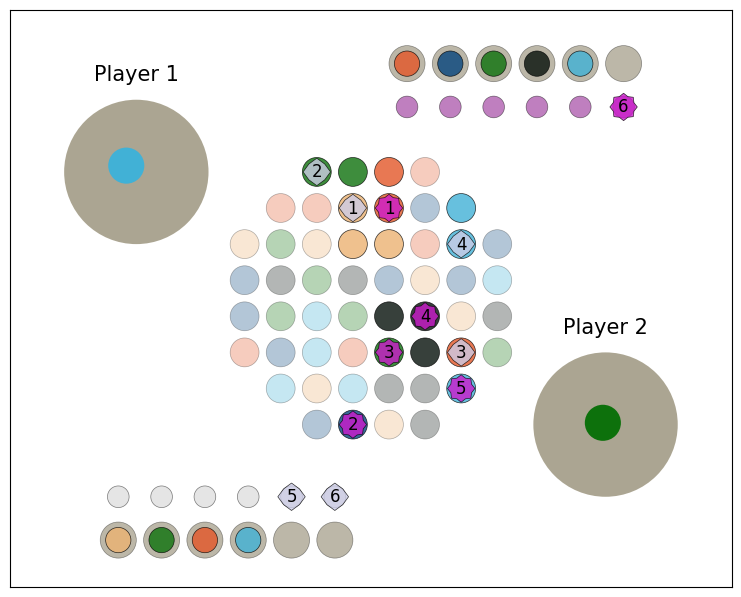

Turn 19, for Player 1
Score is currently:
Player 1: 24 -- 18: Player 2
Available actions are: [46, 55, 100, 98]
action taken is: 98


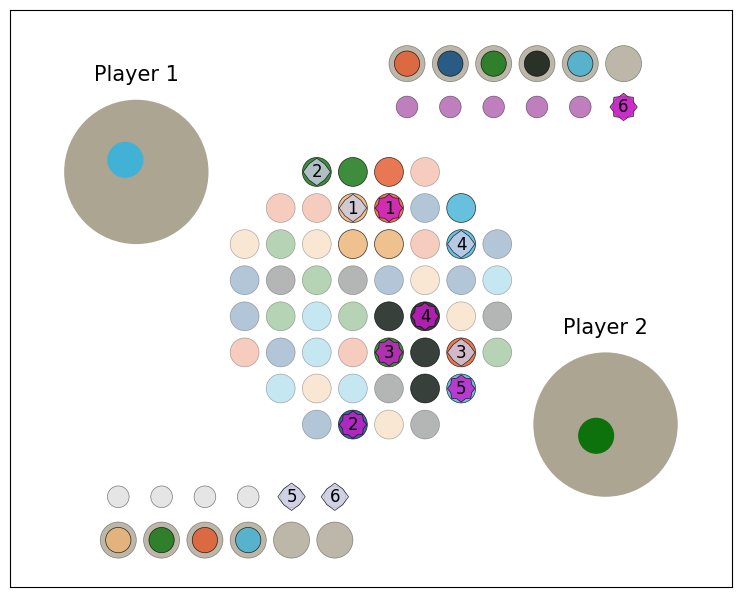

Turn 20, for Player 2
Score is currently:
Player 1: 28 -- 18: Player 2
Available actions are: [5, 64]
action taken is: 64


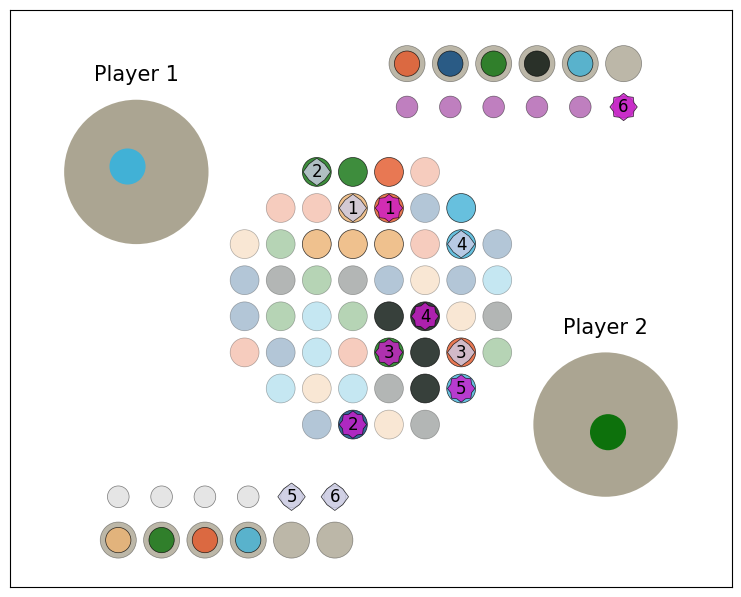

Turn 21, for Player 1
Score is currently:
Player 1: 28 -- 19: Player 2
Available actions are: [55, 100, 97, 103]
###########################
ALERT: no more placing moves from now on!
###########################
action taken is: 103


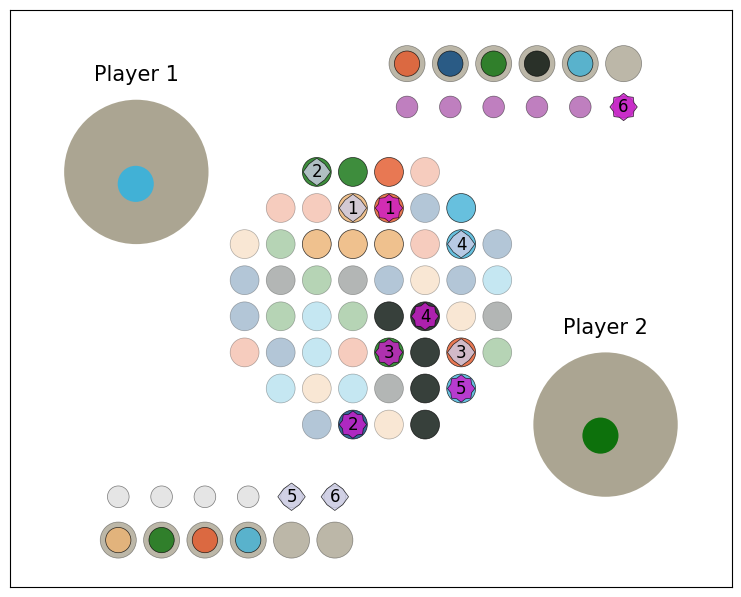

Turn 22, for Player 2
Score is currently:
Player 1: 32 -- 19: Player 2
Available actions are: []


In [7]:
my_patterns = Patterns()
still_placing = True

while True:
    print(f"Turn {my_patterns.turn_number}, for Player {my_patterns.player + 1}")
    print(f"Score is currently:")
    p1_score = my_patterns.active_score if my_patterns.player == 0 else my_patterns.passive_score
    p2_score = my_patterns.active_score if my_patterns.player == 1 else my_patterns.passive_score
    print(f"Player 1: {p1_score} -- {p2_score}: Player 2")
    
    actions = my_patterns.get_actions() 
    print(f"Available actions are: {actions}")
    
    if my_patterns.is_no_more_placing is True and still_placing is True:
        still_placing = False
        print(f"###########################")
        print(f"ALERT: no more placing moves from now on!")
        print(f"###########################")
        
    if not actions: 
        break
    
    action = random.choice(actions)
    print(f"action taken is: {action}")
    my_patterns.step(action)
    
    pattern_plotter = PatternPlotter(my_patterns, fig_size=(10, 7.5))
    pattern_plotter.populate_board()
    

In [ ]:
def play_random_patterns(num_iterations: int) -> None:
    """ play a set number of random games
    """
    for it in range(num_iterations):
        patterns_game = Patterns()

        while True:
            actions = patterns_game.get_actions()
            
            if not actions: 
                break
                
            action = random.choice(actions)
            patterns_game.step(action)

In [ ]:
%prun play_random_patterns(5000)


In [ ]:
jim = chain_test(10)



In [ ]:
import numpy as np


In [ ]:
def est_pi(n):
    """ estimate pi through the perimeter of a polygon
    """
    return 2 ** n * np.sin(np.pi / (2.0 ** n))

est_pi(50)
                                        

In [ ]:
jim = [[1, 2, 3], [4, 5, 6]]
current_jim = jim[0]
current_jim[1] *= 5
current_jim = jim[1]
current_jim[2] = 0

jim2 = [15, 20]
current_jim2 = jim2[0]
current_jim2 *= 10
current_jim2 = jim2[1]
current_jim2 -= 50

jim3 = [{1:2, 3:4}, {5:6, 7:8}]
current_jim3 = jim3[0]
current_jim3[1] *= 5
current_jim3 = jim3[1]
current_jim3[5] += 23

jim, jim2, jim3

In [ ]:
jim = {1: {2}, 3: {4, 5, 6}}
jim.get(2, set(range(52)))

In [ ]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np

token_center = (0.0, 0.0)
outrad = 0.35
inrad = 0.28
num_points = 7
arc = 2. * np.pi / num_points

patch_coords_1 = [
    [token_center[0] + outrad * np.cos(arc * _it),
     token_center[1] + outrad * np.sin(arc * _it)]
    for _it in range(num_points)
]
                
patch_coords_2 = [
    [token_center[0] + inrad * np.cos((arc / 2) + arc * _it),
     token_center[1] + inrad * np.sin((arc / 2) + arc * _it)]
    for _it in range(num_points)
]

patch_coords = []
for p1, p2 in zip(patch_coords_1, patch_coords_2):
    patch_coords.append(p1)
    patch_coords.append(p2)
    
fig, ax = plt.subplots()
ax.add_patch(patches.Polygon(patch_coords, facecolor='red', edgecolor='black', linewidth=0.5))
# ax.add_patch(patches.Polygon(patch_coords_1))
# ax.add_patch(patches.Polygon(patch_coords_2))

ax.set_xlim([-2., 2.])
ax.set_ylim([-2., 2.])
ax.set_aspect('equal')